In [2]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')
import math

# Qiskit packages
# from qiskit_textbook.tools import vector2latex
from qiskit.quantum_info import Statevector
from qiskit.transpiler.passes import Unroller
from qiskit import BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer, assemble, transpile, execute
from qiskit.quantum_info import Pauli, Statevector
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import SPSA
provider = IBMQ.load_account()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from QPSA import (
    initialize_s,
    initialize_Gq,
    diffuser,
    partial_diffuser,
    oracle,
    grover_operator,
    local_grover_operator,
    design_grover_circuit,
    design_partial_grover_circuit,
    classic_grover_stats,
    QPSA_stats,
    design_and_test_two_stage
)
from RunTests import ThreeQubitCases

In [53]:
back = provider.get_backend("ibmq_quito")
simulator = AerSimulator.from_backend(back)

In [55]:
from qiskit.test.mock import FakeManhattan
back = FakeManhattan()
# back = provider.get_backend("ibmq_quito")
simulator = AerSimulator.from_backend(back)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067353 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067403 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067553 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.068201 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067257 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067326 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [8]:
# first test
test = ThreeQubitCases(back, simulator)
test.D2M3()
test.D3M3()
test.D3D3M3()
test.D2M1_D2M2()
test.G1D2M2()

Test D2M3: __________________
gates =  OrderedDict([('rz', 25), ('cx', 14), ('sx', 11), ('measure', 3), ('x', 2), ('barrier', 1)])
P_theoretical:  0.499999999999999
P_actual:  0.3603515625
selectivity:  2.4276315789473686
depth:  34
R_IBM:  0.7207031250000014
expected depth:  94.35230352303523
Test D3M3: __________________
gates =  OrderedDict([('rz', 47), ('cx', 27), ('sx', 24), ('measure', 3), ('x', 2), ('barrier', 1)])
P_theoretical:  0.7812499999999981
P_actual:  0.4716796875
selectivity:  4.351351351351352
depth:  64
R_IBM:  0.6037500000000015
expected depth:  135.68530020703935
Test D3D3M3: __________________
gates =  OrderedDict([('rz', 87), ('sx', 48), ('cx', 47), ('x', 4), ('measure', 3), ('barrier', 1)])
P_theoretical:  0.9453124999999958
P_actual:  0.3896484375
selectivity:  3.5945945945945947
depth:  124
R_IBM:  0.4121900826446299
expected depth:  318.23558897243106
Test D2M1_D2M2: __________________
P_theoretical:  0.4999999999999981
P_actual:  0.4000740051269531
selectivi

In [10]:
config = back.configuration()

In [11]:
config.multi_meas_enabled

True

In [17]:
config.supported_instructions

['acquire',
 'play',
 'shiftf',
 'id',
 'x',
 'rz',
 'u3',
 'reset',
 'sx',
 'setf',
 'cx',
 'u1',
 'u2',
 'delay',
 'measure']

In [56]:
def both(N):
#     N - number of resets in a single reset operation
    qc = QuantumCircuit(3)
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.ccx(0, 1, 2)
    qc.reset([1]*N)
    qc.cx(2,1)
    qc.reset([2]*N)
    # We will return the diffuser as a gate
#     U_s = qc.to_gate()
    qc.name = "Bc$"
    return qc

def multi_controlled_toffoli(n, N):
#     (n-1) - number of controlled qubits
#     N - number of resets in a single reset operation
    qc = QuantumCircuit(n+2)
    # Apply transformation |s> -> |00..0> (H-gates)
    for i in range(n-1):
        qc.append(both(N), [i,n,n+1])
    qc.cx(n, n-1)
    # We will return the diffuser as a gate
#     U_s = qc.to_gate()
    qc.name = "T$"
    return qc

qc = QuantumCircuit(5)
qc.append(multi_controlled_toffoli(3,3), [0,1,2,3,4])
qc.draw()
optimized_3 = transpile(qc, backend=simulator, seed_transpiler=11, optimization_level=1)
print(optimized_3.depth())
# multi_controlled_toffoli(3, 3).draw()

for i in range(3, 20):
    print(i, " qubit case_____________")
    optimized_3 = transpile(multi_controlled_toffoli(i,3), backend=simulator, seed_transpiler=11, optimization_level=1)
    print("with reset: ", optimized_3.depth())
    qc = QuantumCircuit(i)
    qc.mct(list(range(i - 1)), i - 1)
    optimized_3 = transpile(qc, backend=simulator, seed_transpiler=11, optimization_level=1)
    print("without reset: ", optimized_3.depth())

60
3  qubit case_____________
with reset:  60
without reset:  19
4  qubit case_____________
with reset:  104
without reset:  42
5  qubit case_____________
with reset:  132
without reset:  129
6  qubit case_____________
with reset:  156
without reset:  281
7  qubit case_____________
with reset:  193
without reset:  547
8  qubit case_____________
with reset:  221
without reset:  1160
9  qubit case_____________
with reset:  254
without reset:  2430
10  qubit case_____________
with reset:  257
without reset:  4646
11  qubit case_____________
with reset:  272
without reset:  9242
12  qubit case_____________
with reset:  326


KeyboardInterrupt: 

In [44]:
i = 3
qc = QuantumCircuit(i)
qc.mct(list(range(i - 1)), i - 1)
qc.draw()

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

In [34]:
def somr(n):
    qc = QuantumCircuit(3)
    qc.reset([1]*n)
    qc.name = "some"
    return qc
qc = QuantumCircuit(3)
qc.append(somr(3), [0,1,2])
qc.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1 some ├
     │       │
q_2: ┤2      ├
     └───────┘

In [14]:
nqubits = 3
qc = QuantumCircuit(nqubits)
# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(nqubits):
    qc.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc.x(qubit)
# Do multi-controlled-Z gate
qc.h(nqubits - 1)
qc.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
qc.h(nqubits - 1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc.h(qubit)
qc.draw()

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [16]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(3, 2)
# grover_circuit = initialize_Gq(grover_circuit, [0,1,2,3], [0,1], 2)
grover_circuit.ccx(0, 1, 2)
optimized_3 = transpile(grover_circuit, backend=simulator, seed_transpiler=11, optimization_level=1)
print(optimized_3.depth())
optimized_3.draw()

17


global phase: 5π/8
                                                                           »
      q_0 -> 0 ────────────────────────────────────────────────────────────»
                                                                 ┌───┐     »
      q_1 -> 1 ──────────────────────────────■────────────────■──┤ X ├──■──»
               ┌─────────┐┌────┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─┬─┘┌─┴─┐»
      q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├»
               └─────────┘└────┘└─────────┘└───┘└──────────┘└───┘     └───┘»
ancilla_0 -> 3 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_1 -> 4 ────────────────────────────────────────────────────────────»
                                                                           »
          c: 2/════════════════════════════════════════════════════════════»
                                                                           »
«                                                ┌───┐     ┌──────────┐»
«      q_0 -> 0 ──■──────────────────────────────┤ X ├──■──┤ Rz(3π/4) ├»
«               ┌─┴─┐┌─────────┐┌───┐┌──────────┐└─┬─┘┌─┴─┐└──────────┘»
«      q_1 -> 1 ┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├──■──┤ X ├─────■──────»
«               └───┘└─────────┘└─┬─┘├─────────┬┘     └───┘   ┌─┴─┐    »
«      q_2 -> 2 ──────────────────■──┤ Rz(π/4) ├──────────────┤ X ├────»
«                                    └─────────┘              └───┘    »
«ancilla_0 -> 3 ───────────────────────────────────────────────────────»
«                                                                      »
«ancilla_1 -> 4 ───────────────────────────────────────────────────────»
«                                                                      »
«          c: 2/═══════════════════════════════════════════════════════»
«                                                                      »
«                  ┌────┐   ┌─────────┐
«      q_0 -> 0 ───┤ √X ├───┤ Rz(π/2) ├
«               ┌──┴────┴─┐ └─────────┘
«      q_1 -> 1 ┤ Rz(π/4) ├──────■─────
«               ├─────────┴┐   ┌─┴─┐   
«      q_2 -> 2 ┤ Rz(-π/4) ├───┤ X ├───
«               └──────────┘   └───┘   
«ancilla_0 -> 3 ───────────────────────
«                                      
«ancilla_1 -> 4 ───────────────────────
«                                      
«          c: 2/═══════════════════════
«

{'00000': 0.015624999999999965, '00001': 0.01562499999999998, '00010': 0.39062499999999917, '00011': 0.01562499999999998, '00100': 0.015624999999999972, '00101': 0.015624999999999972, '00110': 0.015624999999999962, '00111': 0.015624999999999972, '01000': 0.015624999999999965, '01001': 0.01562499999999998, '01010': 0.39062499999999917, '01011': 0.01562499999999998, '01100': 0.015624999999999972, '01101': 0.015624999999999972, '01110': 0.015624999999999962, '01111': 0.015624999999999972}
P_theoretical:  0
gates =  OrderedDict([('rz', 52), ('cx', 33), ('sx', 25), ('x', 3), ('measure', 3), ('barrier', 1)])
depth =  79
S:  6.151162790697675
1024 529
P_actual:  51.66015625 %


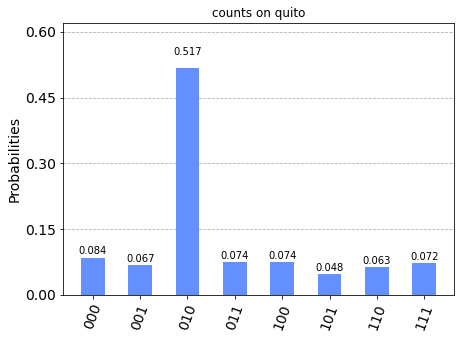

In [29]:
n = 3
m = 2
j = [0, 1]
h = [0,1,0]
res = DesignPartialGroverCircuit(n, m, j, h)
ClassicGroverStats(res, h, n)
# res.draw()

In [11]:
design_and_test_two_stage(3, 2, [1, 0], 2, [1, 0], [1, 0, 1], back)

P_theoretical:  0.4999999999999992
gates =  OrderedDict([('rz', 36), ('cx', 27), ('sx', 16), ('x', 2), ('barrier', 1), ('measure', 1)])
depth =  61
S:  0.9504761904761905
1024 499
P_actual:  48.73046875 %
P_theoretical:  0.624999999999999
gates =  OrderedDict([('rz', 36), ('cx', 27), ('sx', 16), ('x', 2), ('measure', 2), ('barrier', 1)])
depth =  61
S:  2.382775119617225
1024 498
P_actual:  48.6328125 %


(0.9504761904761905, 0.7583679199218775, 122, 514.7897079299161)

In [37]:
min([0,1])

ibmqfactory.load_account:WARNING:2022-04-14 19:54:27,228: Credentials are already in use. The existing account in the session will be replaced.


0

P_theoretical:  0.4999999999999991
gates =  OrderedDict([('rz', 37), ('cx', 27), ('sx', 16), ('x', 4), ('measure', 2), ('barrier', 1)])
depth =  61
S:  1.7413127413127414
1024 451
P_actual:  44.04296875 %


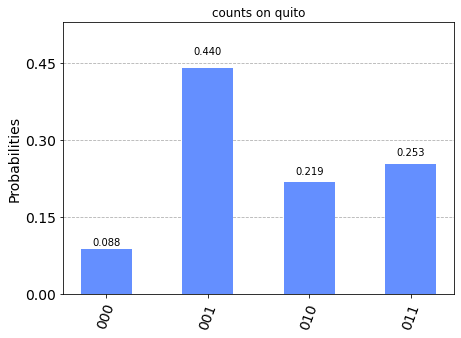

In [41]:
n = 3
m = 2
j = [1, 0]
h = [0,1,0]
partial_state = [0, 1]
res = design_partial_grover_circuit(n, m, j, h)
(_, _, _, _, a) = QPSA_stats(res, partial_state, n)
a

ibmqfactory.load_account:WARNING:2022-04-14 19:41:45,475: Credentials are already in use. The existing account in the session will be replaced.


{'0000': 0.015624999999999965, '0001': 0.01562499999999998, '0010': 0.39062499999999917, '0011': 0.01562499999999998, '0100': 0.015624999999999972, '0101': 0.015624999999999972, '0110': 0.015624999999999962, '0111': 0.015624999999999972, '1000': 0.015624999999999965, '1001': 0.01562499999999998, '1010': 0.39062499999999917, '1011': 0.01562499999999998, '1100': 0.015624999999999972, '1101': 0.015624999999999972, '1110': 0.015624999999999962, '1111': 0.015624999999999972}
P_theoretical:  0.8124999999999983
gates =  OrderedDict([('rz', 52), ('cx', 33), ('sx', 25), ('x', 3), ('measure', 2), ('barrier', 1)])
depth =  79
S:  4.074829931972789
1024 599
P_actual:  58.49609375 %


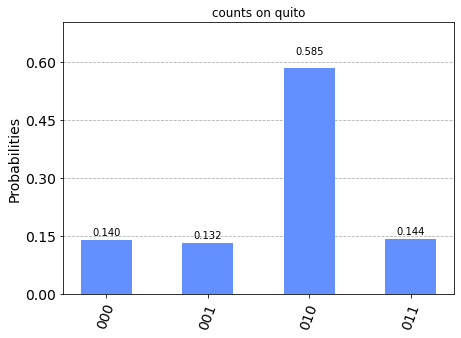

In [36]:
n = 3
m = 2
j = [0, 1]
h = [0,1,0]
partial_state = [1, 0]
res = design_partial_grover_circuit(n, m, j, h)
(_, _, _, a) = QPSA_stats(res, partial_state, n, False)
a

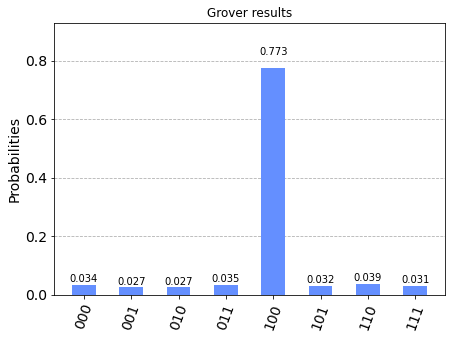

In [61]:
# run locally
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
circ = transpile(grover_circuit_sim, sim)
result = sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Grover results')

In [62]:
print(counts)

{'100': 792, '010': 28, '110': 40, '101': 33, '111': 32, '000': 35, '011': 36, '001': 28}


In [12]:
circ.draw()

┌───┐          ┌─────────┐      ┌───────────┐ ░ ┌─┐         
   q_0: ────┤ H ├──────■───┤ U2(0,0) ├───■──┤ U2(-π,-π) ├─░─┤M├─────────
         ┌──┴───┴──┐   │   ├─────────┴┐  │  ├───────────┤ ░ └╥┘┌─┐      
   q_1: ─┤ U2(0,0) ├───■───┤ U2(-π,0) ├──■──┤ U2(-π,-π) ├─░──╫─┤M├──────
         ├─────────┤   │  ┌┴──────────┤┌─┴─┐└─┬────────┬┘ ░  ║ └╥┘┌─┐   
   q_2: ─┤ U2(0,0) ├───■──┤ U3(π,0,0) ├┤ X ├──┤ U1(-π) ├──░──╫──╫─┤M├───
        ┌┴─────────┴┐┌─┴─┐└───────────┘└───┘  └────────┘  ░  ║  ║ └╥┘┌─┐
   q_3: ┤ U2(-π,-π) ├┤ X ├────────────────────────────────░──╫──╫──╫─┤M├
        └───────────┘└───┘                                ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

In [28]:
# the depth of our circuit heavily depends on the device topology and base operations we are allowed to use.
# In order to define this we will mock the Vigo device

from qiskit.test.mock import FakeVigo
fv = FakeVigo()
optimized_3 = transpile(grover_circuit, backend=fv, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('rz', 89), ('cx', 60), ('sx', 45), ('measure', 4), ('x', 2), ('barrier', 1)])
depth =  139


In [30]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [51]:
from qiskit.tools.jupyter import *
back = provider.get_backend("ibmq_quito")
optimized_3 = transpile(grover_circuit, backend=back, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('rz', 20), ('sx', 12), ('cx', 11), ('x', 1)])
depth =  30


In [54]:
back

RequestsApiError: '403 Client Error: Forbidden for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/devices/ibmq_quito/queue/status. <!DOCTYPE html>\n<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->\n<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->\n<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->\n<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->\n<head>\n<title>Access denied | api.quantum-computing.ibm.com used Cloudflare to restrict access</title>\n<meta charset="UTF-8" />\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />\n<meta http-equiv="X-UA-Compatible" content="IE=Edge" />\n<meta name="robots" content="noindex, nofollow" />\n<meta name="viewport" content="width=device-width,initial-scale=1" />\n<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />\n\n\n<script>\n(function(){if(document.addEventListener&&window.XMLHttpRequest&&JSON&&JSON.stringify){var e=function(a){var c=document.getElementById("error-feedback-survey"),d=document.getElementById("error-feedback-success"),b=new XMLHttpRequest;a={event:"feedback clicked",properties:{errorCode:1009,helpful:a,version:1}};b.open("POST","https://sparrow.cloudflare.com/api/v1/event");b.setRequestHeader("Content-Type","application/json");b.setRequestHeader("Sparrow-Source-Key","c771f0e4b54944bebf4261d44bd79a1e");\nb.send(JSON.stringify(a));c.classList.add("feedback-hidden");d.classList.remove("feedback-hidden")};document.addEventListener("DOMContentLoaded",function(){var a=document.getElementById("error-feedback"),c=document.getElementById("feedback-button-yes"),d=document.getElementById("feedback-button-no");"classList"in a&&(a.classList.remove("feedback-hidden"),c.addEventListener("click",function(){e(!0)}),d.addEventListener("click",function(){e(!1)}))})}})();\n</script>\n\n<script defer src="https://api.radar.cloudflare.com/beacon.js"></script>\n</head>\n<body>\n  <div id="cf-wrapper">\n    <div class="cf-alert cf-alert-error cf-cookie-error hidden" id="cookie-alert" data-translate="enable_cookies">Please enable cookies.</div>\n    <div id="cf-error-details" class="p-0">\n      <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-15 antialiased">\n         <h1 class="inline-block md:block mr-2 md:mb-2 font-light text-60 md:text-3xl text-black-dark leading-tight">\n           <span data-translate="error">Error</span>\n           <span>1009</span>\n         </h1>\n         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">Ray ID: 7018b6ae2b3875bb &bull;</span>\n         <span class="inline-block md:block heading-ray-id font-mono text-15 lg:text-sm lg:leading-relaxed">2022-04-25 17:14:11 UTC</span>\n        <h2 class="text-gray-600 leading-1.3 text-3xl lg:text-2xl font-light">Access denied</h2>\n      </header>\n\n      <section class="w-240 lg:w-full mx-auto mb-8 lg:px-8">\n          <div id="what-happened-section" class="w-1/2 md:w-full">\n            <h2 class="text-3xl leading-tight font-normal mb-4 text-black-dark antialiased" data-translate="what_happened">What happened?</h2>\n            <p>The owner of this website (api.quantum-computing.ibm.com) has banned the country or region your IP address is in (RU) from accessing this website.</p>\n            \n          </div>\n\n          \n      </section>\n\n      <div class="feedback-hidden py-8 text-center" id="error-feedback">\n    <div id="error-feedback-survey" class="footer-line-wrapper">\n        Was this page helpful?\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-yes" type="button">Yes</button>\n        <button class="border border-solid bg-white cf-button cursor-pointer ml-4 px-4 py-2 rounded" id="feedback-button-no" type="button">No</button>\n    </div>\n    <div class="feedback-success feedback-hidden" id="error-feedback-success">\n        Thank you for your feedback!\n    </div>\n</div>\n\n\n      <div class="cf-error-footer cf-wrapper w-240 lg:w-full py-10 sm:py-4 sm:px-8 mx-auto text-center sm:text-left border-solid border-0 border-t border-gray-300">\n  <p class="text-13">\n    <span class="cf-footer-item sm:block sm:mb-1">Cloudflare Ray ID: <strong class="font-semibold">7018b6ae2b3875bb</strong></span>\n    <span class="cf-footer-separator sm:hidden">&bull;</span>\n    <span class="cf-footer-item sm:block sm:mb-1"><span>Your IP</span>: 188.243.183.201</span>\n    <span class="cf-footer-separator sm:hidden">&bull;</span>\n    <span class="cf-footer-item sm:block sm:mb-1"><span>Performance &amp; security by</span> <a rel="noopener noreferrer" href="https://www.cloudflare.com/5xx-error-landing" id="brand_link" target="_blank">Cloudflare</a></span>\n    \n  </p>\n</div><!-- /.error-footer -->\n\n\n    </div><!-- /#cf-error-details -->\n  </div><!-- /#cf-wrapper -->\n\n  <script>\n  window._cf_translation = {};\n  \n  \n</script>\n\n</body>\n</html>\n'

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.save_account("43456020bee4d8426003db5dc03dd22613d52b46d72c444a55aa2729c8c5609789ef4535c06b9ea7156441c250347eb8695ca9eb3dd84c2e9726b3942e5b518c")

configrc.store_credentials:WARNING:2022-04-21 12:39:01,522: Credentials already present. Set overwrite=True to overwrite.


In [34]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

NameError: name 'least_busy' is not defined

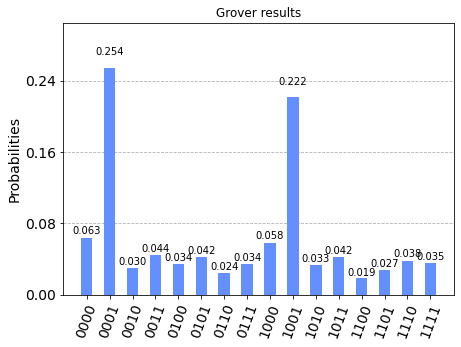

In [32]:
n = 3
grover_circuit = QuantumCircuit(n+1)
grover_circuit.x(3)
grover_circuit.h(3)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(Grover_operator(n, [1,0,0]), [0,1,2,3])
grover_circuit.measure_all()

result = execute(grover_circuit, fv).result()
counts = result.get_counts()
plot_histogram(counts, title='Grover results')

In [66]:
def AlgoStats(counts, state, n):
    m = len(state)
    strState = ''.join(str(e) for e in state)
    summ = 0;
    res = 0;
    max_ = 0;
    for strin in counts:
        summ += counts[strin]
        if strin == strState:
            res += counts[strin]
        else:
            if max_ < counts[strin]:
                max_ = counts[strin]
                
    Pactual = res/summ
    S = Pactual/max_
    print(summ, res)
    print(res*100/summ, "%")
    return (Pactual, S)

P_theoretical:  0.47265624999999867
gates =  OrderedDict([('rz', 123), ('cx', 85), ('sx', 59), ('x', 6), ('measure', 4), ('barrier', 1)])
depth =  179
S:  1.9213483146067416
1024 171
P_actual:  16.69921875 %


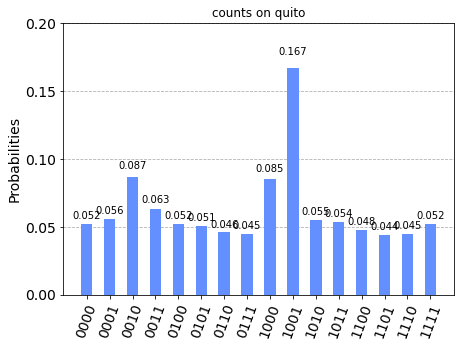

In [41]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

P_theoretical:  0.9084472656249958
gates =  OrderedDict([('rz', 244), ('cx', 193), ('sx', 121), ('x', 13), ('measure', 4), ('barrier', 1)])
depth =  383
S:  0.00123291015625
1024 101
P_actual:  9.86328125 %


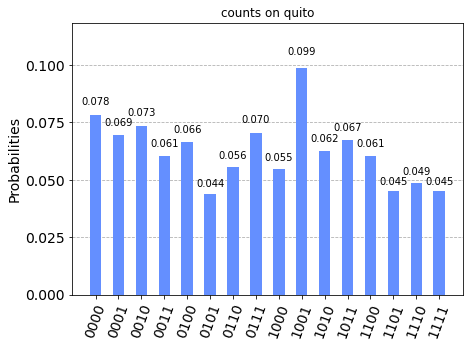

In [38]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

P_theoretical:  0.9613189697265565
gates =  OrderedDict([('rz', 342), ('cx', 298), ('sx', 160), ('x', 16), ('measure', 4), ('barrier', 1)])
depth =  558
S:  0.0008077739197530864
1024 67
P_actual:  6.54296875 %


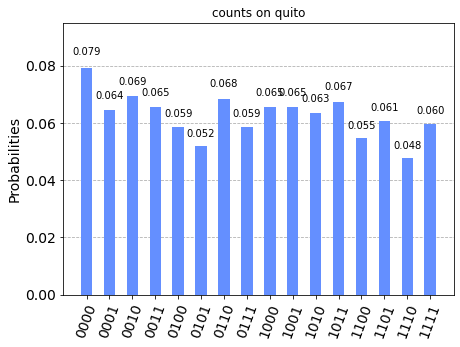

In [39]:
n = 4
h = [1,0,0,1]
grover_circuit = QuantumCircuit(n+1, 4)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.x(4)
grover_circuit.h(4)
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.append(Grover_operator(n, h), [0,1,2,3,4])
grover_circuit.draw()
res = ClassicGroverStats(grover_circuit, h, n)
res

In [13]:
h=[0,0,1,1,0]
h[5-4:(5-4)+2]

[0, 1]